# Causal analysis of event data 

*Tsuyoshi (Ide-san) Ide, Georgios Kollias, Naoki Abe*

## Introduction

Timestamped events, such as warnings, alerts, maintenance records, failure logs, etc., are commonly observed types of data in condition-based maintenance of industrial systems. Timestamped events require specific mathematical tools that are quite different from those for i.i.d. (identically and independently distributed) vectors. They are doubly stochastic in the sense that both event arrival intervals and event types have to be treated as random variables. This is one of the major reasons why directly analyzing timestamped events has been thought of as a challenging task. 

We recently proposed a new framework that we call the Hawkes-Granger model for causal event diagnosis. Major practical features include:

- **Causal**. It strictly distinguishes correlation and causation based on the notion of [Granger causality](https://en.wikipedia.org/wiki/Granger_causality).
- **Capable of analyzing both instance- and class-level causal relationships**. 
- **Window-free**. No need to fine-tune window size. Time constants are automatically learned for each event type.
- **Interpretable**. The guaranteed mathematical sparsity allows prioritizing many possibilities. 

**L0Hawkes** is the name of the algorithm we developed to find the solution for the Hawkes-Granger model. It, for the first time, allows *sparse* causal analysis of multivariate temporal events in a mathematically guaranteed way. Mathematical sparsity in the model plays a critical role in causal analysis, i.e., in answering "**who caused this?**" since it allows us to focus on fewer possible causes. Otherwise, we either need to examine thousands of possibilities or rely on rather precarious statistical tests, whose theoretical assumptions are often inconsistent with the real-world setting. For technical details, see:

> Tsuyoshi Idé, Georgios Kollias, Dzung T. Phan, Naoki Abe, "[Cardinality-Regularized Hawkes-Granger Model](https://proceedings.neurips.cc/paper/2021/hash/15cf76466b97264765356fcc56d801d1-Abstract.html)," Advances in Neural Information Processing Systems 34 (NeurIPS 2021). ([slides](https://neurips.cc/media/neurips-2021/Slides/27855_O3GiVn6.pdf)).

This notebook provides an overview of a Python implementation of our model and how it works. 

## Problem setting

The below figure schematically illustrates the input and the output of the specific algorithm named **L0Hawkes** we have implemented. There are two types of input data:

- `timestamps`: $t_0, t_1, \ldots, t_N$,
- `event_types`: $d_0, d_1, \ldots, d_N$,

where $t_n$ a real-valued number representing the timestamp of the n-th event and $d_n$ is the event type, which is in general a string representing one of $D$ event types. Note that the zeroth event is called the genesis event and treated differently from the others because it has no history recorded in the data. $N$ is therefore defined as `N = len(timestamps)-1`.

The main goal of the algorithm is to perform instance-level causal analysis by computing causal **triggering probabilities** for each event instances. Specifically, L0Hawkes outputs 
- `qself`: Self-triggering probabilities. `qself[n]` gives the self-triggering probability of the n-th event instance.
- `qhist`: Causal triggering probabilities. `qhist[n,i]` gives the causal triggering probability of the i-th event in the n's history. 

![](L0Hawkes_overview.png)

In addition to these instance-level quantities, L0Hawkes outputs three class-level statistics:

- `A`: $D\times D$ class-level Granger-causal matrix. `A[k,l]` represents the strength of causal relationship $k \leftarrow l$, i.e., how strongly the type $k$ events are caused by the type $l$ events.
- `beta`: Decay parameters. $D$-dimensional vector, where `beta[k]` is the decay parameter of the $k$-th event type. One way of interpreting `beta[k]` is the reciprocal of the time-scale of influence of the type-k. 
- `mu`: Baseline intensity. $D$-dimensional vector, where `mu[k]` is the baseline intensity of the $k$-th event type.  Baseline intensity represents the spontaneous occurrence rate of each event type.

## Input and output data structure

The input of the algorithm is two one-dimensional arrays with $N+1$ entries, as described above. 

Regarding the output, the data structure of the class-level quantities is relatively straightforward. `A` is a two-dimensional Numpy array ($D\times D$ matrix), `beta` and `mu` are one-dimensional arrays of $D$ entries. 

For the instance level quantities, there is one important parameter `Nh`, which specifies how many instances are kept in the history. For instance, **if** `Nh=4`, the data structure of `qhist,qself` will be:
$$
    \mathtt{qhist}=
    \begin{pmatrix}
        \mathtt{nan} & \mathtt{nan} & \mathtt{nan} & \mathtt{nan} \\
        q_{1,0} & \mathtt{nan} & \texttt{nan} & \mathtt{nan} \\
        q_{2,0} & q_{2,1} & \mathtt{nan} & \mathtt{nan} \\
        q_{3,0} & q_{3,1} & q_{3,2} & \mathtt{nan} \\
        q_{4,0} & q_{4,1} & q_{4,2} & q_{4,3} \\
        q_{5,1} & q_{5,2} & q_{5,3} & q_{5,4} \\
        \vdots & \vdots & \vdots & \vdots \\
        q_{N,N-4} & q_{N,N-3} & q_{N,N-2} & q_{N,N-1}
    \end{pmatrix},
    \quad
    \mathtt{qself}=
    \begin{pmatrix}
        \mathtt{nan}\\
        q_{1,1}\\
        q_{2,2}\\
        q_{3,3}\\
        q_{4,4}\\
        q_{5,5}\\
        \vdots \\
        q_{N,N}
    \end{pmatrix}
$$
Here $q_{n,i}$ is the triggering probability $n \leftarrow i$ ($n$ is caused by $i$). `qhist` is an $(N+1) \times N_h$ matrix. The zero-th row of `qhist` is for the genesis event and all nan. The first row has only one entry $q_{1,0}$ because only the zero-th event can causally influence the first event. For $n \geq N_h$, there are exactly $N_h$ causal triggers. `Nh=4` in the above for illustration purposes. It typically is on the order of 100 or even 1000. See the below demos.

![](L0Hawkes_Nh.png)

----
## Demo: learning causal structure from event data

We synthetically generated a benchmark dataset named `Sparse5` with a standard point process simulator called [tick](https://x-datainitiative.github.io/tick/index.html). This dataset includes five different datasets that were independently generated. Those five datasets are five-dimensional event data, i.e., $D=5$, and contain roughly $N \approx 1000$ events. Let us use the zeroth one by specifying `data_idx = 0`.

### Loading `Sparse5` data

In [1]:
%%time
# Reading data
import bz2
import pickle
datafolder = './demodata/'
fn = 'Sparse5.pickle.bz2'
with bz2.open(datafolder + fn,'rb') as f:
    data = pickle.load(f)

data_idx = 0 # Use the zeroth dataset

event_types = data[data_idx].get('et')
timestamps = data[data_idx].get('ts')
print('N={} events loaded'.format(len(timestamps)))

N=966 events loaded
CPU times: total: 188 ms
Wall time: 310 ms


### Showing distribution of events
In the `L0HawkesVisualize` module, we have implemented a few useful tools for visualization. The `show_multivariate_points()` function visualizes how timestamps distribute over time for each of the event types. In the below example, the first to fifth rows from the top correspond to the distribution for $k=1$ to $k=5$ event types, respectively. 

As shown, significant *non-uniformity* along time is observed. This is, in fact, a major characteristic of real-world event data from data centers, as discussed below, and this is the very characteristic the underlying point-process model called the Hawkes model was developed for. Because of the non-uniformity, the use of a single window size to correlate event instances make little sense. 

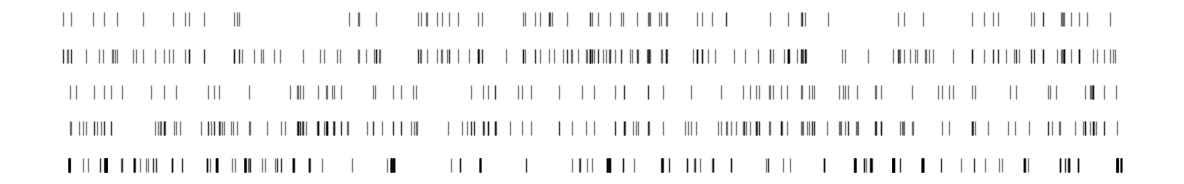

In [2]:
# Plotting the data
import L0HawkesVisualize
import numpy as np
event_list = np.unique(event_types)
event_list,plt,fig,axes, = L0HawkesVisualize.show_multivariate_points(timestamps,event_types,figsize=(12,2))

### Training Granger-Hawkes model using L0Hawkes algorithm

The `L0HawkesLibCoreTS` module implements the L0Hawkes algorithm. For N=966, we use `Nh=100`. L0Hawkes is an iterative algorithm. The degree of convergence is controlled with two parameters `itr_max` and `err_threshold`, which are set to 50 and $10^{-4}$ by default. If the log-likelihood is still on an upward trend when the number of iterations reached `itr_max`, these parameters can be adjusted. 

`L0HawkesVisualize.show_model()` conveniently shows a summary of the class-level model parameters. The log-likelihood is a goodness-of-fit measure and is supposed to increase in the course of iterations. The decay parameter `beta` and the baseline intensity `mu` are plotted in the bar charts. The heatmap visualizes `A`, where off-diagonal elements are omitted by specifying `show_diagonal=False`. We see that only two elements are nonzero while everything else is exact zero, thanks to the sparse causal learning algorithm.  

For this data, the ground truth is as follows. The *off-diagonal elements of A perfectly reproduce the ground truth* up to a scaling factor, which cannot be determined by the underlying point process model. 

$$
\mathtt{mu}=
    \begin{pmatrix}
    0.001\\
    0.001\\
    0.001\\
    0.001\\
    0.001
    \end{pmatrix}, \quad
    \mathtt{beta}  = 
    \begin{pmatrix}
    0.5\\
    0.5\\
    0.1\\
    0.1\\
    0.1
    \end{pmatrix}
    ,\quad
\mathtt{A} = \begin{pmatrix}
0.   &0.   &0.   &0.   &0.  \\
1.5  &0.   &0.   &0.   &0.  \\
0.   &0.   &0.   &0.   &0.  \\
0.   &0.   &1.5  &0.   &0.  \\
0.   &0.   &0.   &0.   &0.75
\end{pmatrix},
$$

There are subtle indistinguishability issues between `mu`, `beta`, and the diagonal elements of `A` in the Granger-Hawkes model. They are learned to maximize the likelihood "as a whole". Reproducing the exact individual values is generally challenging. Even in that case, however, the *off-diagonal* elements of `A` uncovers the causal structure between event types.  

In [4]:
%%time
# Training Granger-Hawkes model
import L0HawkesLib
Nh = 100
result = L0HawkesLib.L0HawkesNh(timestamps, event_types, Nh)

---- N(#events)=965, D(#types)=5, Nh(hist.size)=100
---- itr_max=50,residual threshold=0.0001
  10:residual(mu,beta,A)=(0.01084,0.04292,0.00373),loglik=-4215.2235894428995
  20:residual(mu,beta,A)=(0.00008,0.00660,0.00002),loglik=-4210.266494219885
  30:residual(mu,beta,A)=(0.00006,0.02903,0.00000),loglik=-4209.139952462697
  40:residual(mu,beta,A)=(0.00002,0.00445,0.00000),loglik=-4209.0697677503285
  50:residual(mu,beta,A)=(0.00000,0.00235,0.00000),loglik=-4208.869086008948
	sparse_level=0.75(tau=1.099), nu_A=0.1, eps=0.01
	decayfunc=power, nu_beta=0.1, a_beta=1.01, b_beta=0.01
	prior=gg, nu_mu=0.1, a_mu=1.001, b_mu=0.01, final loglik=-4208.869086008948
CPU times: total: 5.84 s
Wall time: 9.21 s


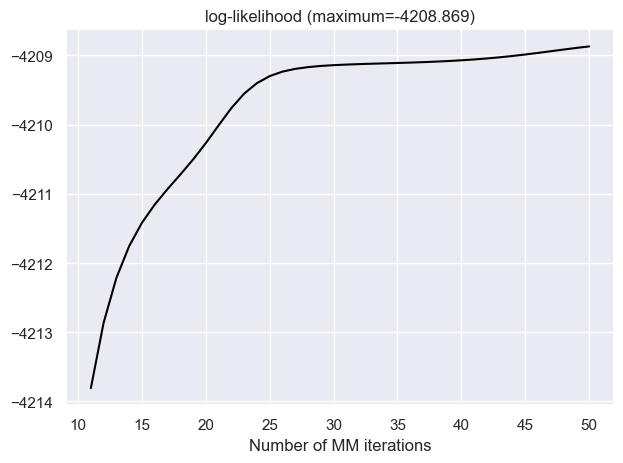

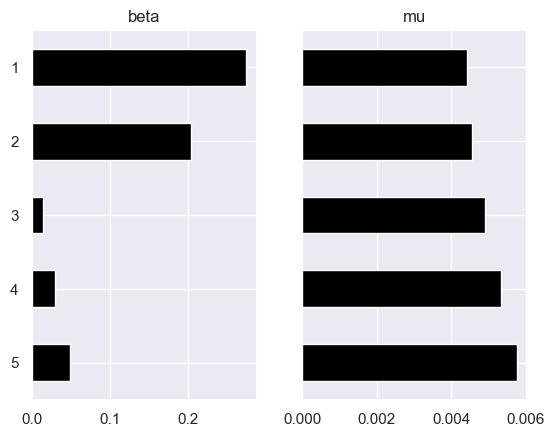

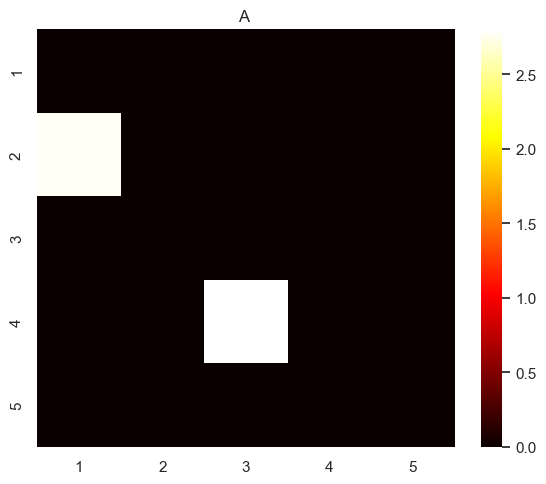

In [5]:
# Showing result
_ = L0HawkesVisualize.show_model(result,show_diagonal=False)

### Causal analysis of a specific instance

In addition to the class-level causal relationship, L0Hawkes can learn instance-instance causal relations. Let us take a look at a specific instance, say, the 888th instance. `L0HawkesVisualize.show_causal_triggers_of()` shows a bar chart of the triggering probabilities. In the below, the self triggering probability $q_{888,888}$ is rightmost and highlighed in red. The bars plot
$$
q_{888,853}, \ldots, q_{888,887}, q_{888,888}
$$
from left to right, which sum to one. The number of bars displayed can be controlled by `num_bars`, which is 25 by default. See the API document for other parameters.

From the bar chart, we see that the 888th instance (event type is 2) seems to have been triggered by the 884th instance (event type is 1). This is exactly what you would expect from the class-level Granger causal matrix `A`, in which $A_{2,1}$ takes a nonzero value.

c:\Users\IDE-SANIDE\Box Sync\home\SemiconML\HawkesGranger\L0HawkesVisualize.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabel,fontsize=fontsize_label,rotation=90)


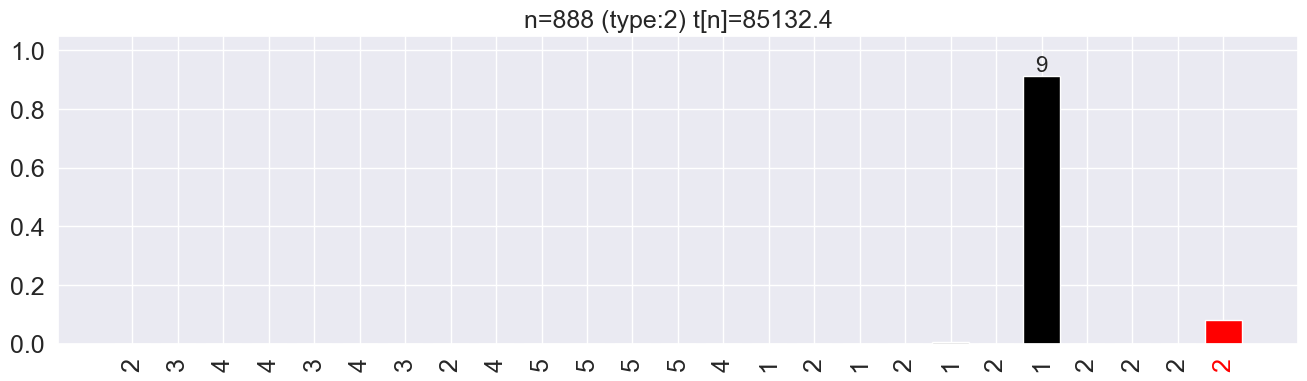

In [6]:
# Shoing triggering prpbabilities
qself = result.get('learned_params').get('qself')
qhist = result.get('learned_params').get('qhist')
n = 888
_,_ = L0HawkesVisualize.show_causal_triggers_of(n,qself,qhist,timestamps,event_types,time_unit='')

### Proposed test case

As `Sparse5` dataset has the ground truth, the above example can be used as a test case. Upon getting the result, one can check whether 
- $A_{2,1}>0$ and $A_{4,3}>0$ (In the data, event types 1,2,3,4,5 are defined. They are mapped onto Python's indices 0,1,2,3,4, respectively. `A[1,0] > 0` and `A[3,2] > 0` should be checked) AND
- All the other 18 off-diagonal elements are zero. 